# **Dataset Download & Extraction**

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alessiocorrado99/animals10
!unzip -q animals10.zip -d animals10

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


# **Importing Libraries**

This section includes all the essential libraries for data handling, visualization, image preprocessing, and building the convolutional neural network (CNN) model.


In [2]:
import numpy as np
import pandas as pd
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# **Loading Image Paths and Labels**

Gather all image paths and assign class labels. Italian class names are mapped to English.

In [3]:
data_dir = '/content/animals10/raw-img'

label_map = {
    'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant',
    'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat',
    'mucca': 'cow', 'pecora': 'sheep', 'ragno': 'spider', 'scoiattolo': 'squirrel'}

image_paths = glob.glob(os.path.join(data_dir, "*", "*.*"))
df = pd.DataFrame({
    'path': image_paths,
    'label': [label_map[os.path.basename(os.path.dirname(p))] for p in image_paths]
})


# **Class Distribution**

This pie chart shows the proportion of images in each class within the Animals-10 dataset.  
It helps assess class imbalance.

- The dataset is relatively imbalanced.
- The "dog" and "spider" classes dominate, each contributing nearly 18% of the data.
- The "elephant" and "cat" classes are underrepresented.


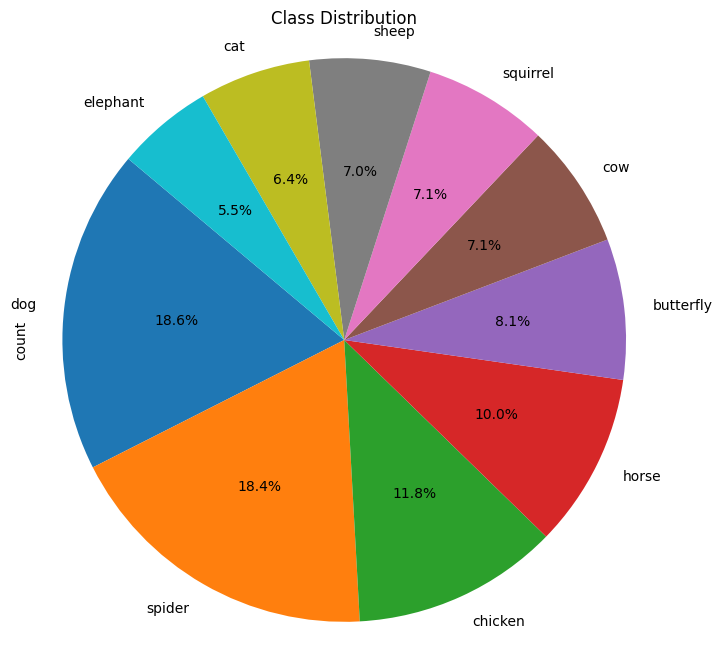

In [4]:
plt.figure(figsize=(8, 8))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# **Visualizing Random Sample Images**

Display one random image from each class to get an overview of the dataset content.

In [ ]:
def get_random_images(df, img_per_class=1):
    return df.groupby('label').sample(n=img_per_class).reset_index(drop=True)



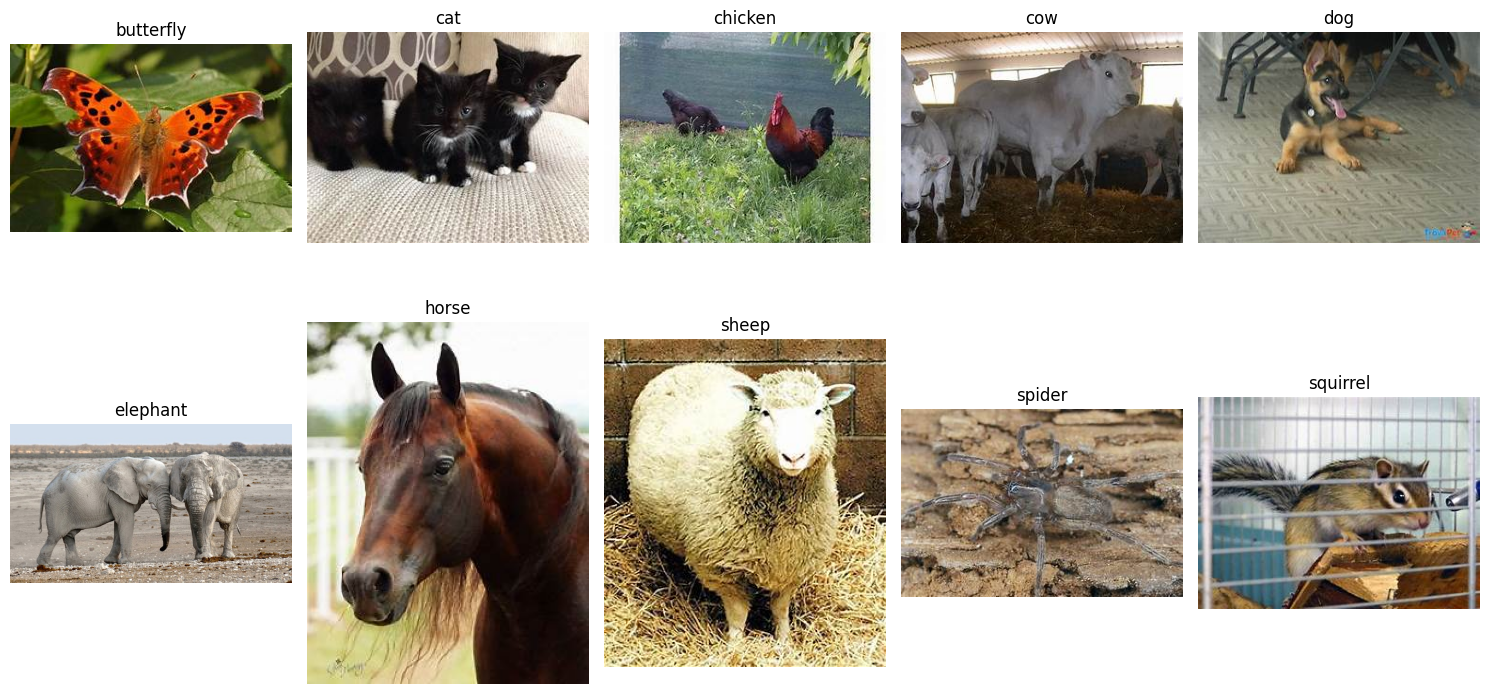

In [ ]:



sample_img = get_random_images(df)
plt.figure(figsize=(15, 8))
for idx, row in sample_img.iterrows():
    img = mpimg.imread(row['path'])
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Histogram Equalization**

Apply histogram equalization on the Y channel (brightness) of each image to enhance contrast and improve model performance.


In [ ]:
def hist_equalization(df, save_dir='temp_eq'):
    os.makedirs(save_dir, exist_ok=True)
    processed = []
    for _, row in df.iterrows():
        img = cv2.imread(row['path'])
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        equalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        # Save equalized image to disk
        filename = os.path.basename(row['path'])
        save_path = os.path.join(save_dir, filename)
        cv2.imwrite(save_path, cv2.cvtColor(equalized, cv2.COLOR_RGB2BGR))
        processed.append({'path': save_path, 'label': row['label']})
    return pd.DataFrame(processed)

In [ ]:

original_img = get_random_images(df)
equalized_img = hist_equalization(original_img)

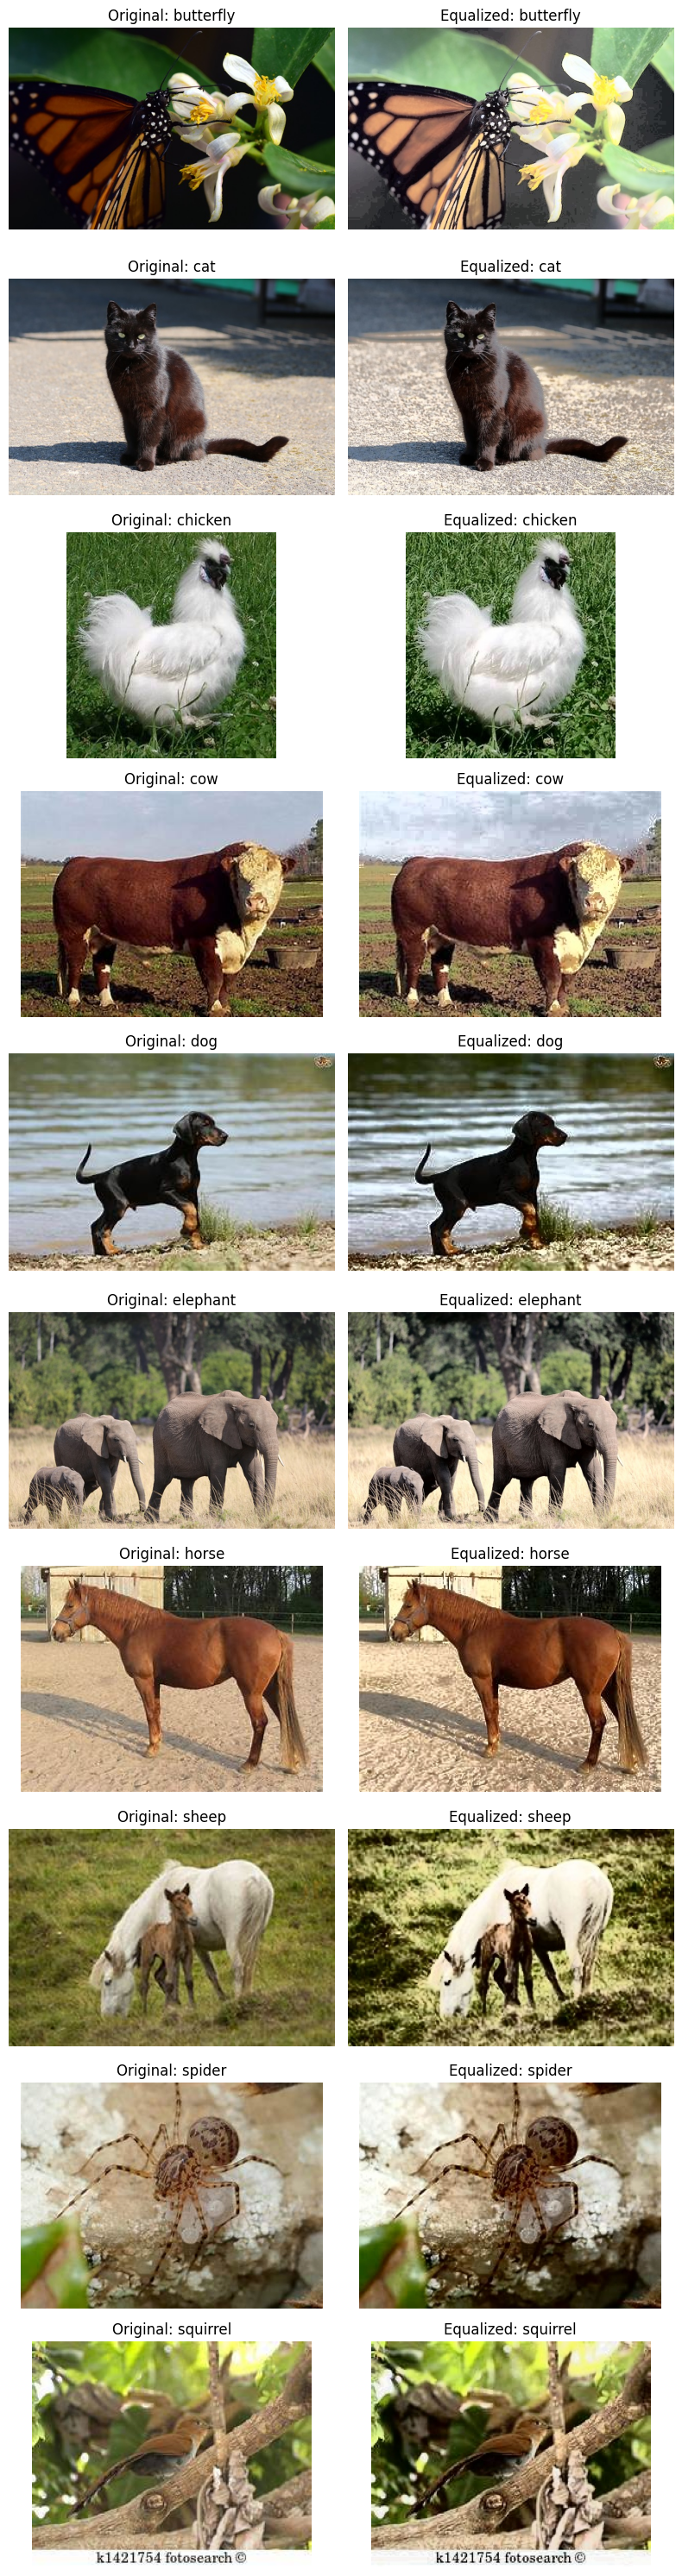

In [9]:
plt.figure(figsize=(8, 3 * 10))

for i, (org_row, eq_row) in enumerate(zip(original_img.itertuples(), equalized_img.itertuples())):
    # Original image
    plt.subplot(10, 2, 2*i + 1)
    img = mpimg.imread(org_row.path)
    plt.imshow(img)
    plt.title(f"Original: {org_row.label}")
    plt.axis('off')

    # Equalized image
    plt.subplot(10, 2, 2*i + 2)
    img_eq = mpimg.imread(eq_row.path)
    plt.imshow(img_eq)
    plt.title(f"Equalized: {eq_row.label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Splitting Dataset**

Split the dataset into training (80%), validation (10%), and test (10%) sets, ensuring class balance using stratification.


In [33]:
processed_df = hist_equalization(df)

train_df, temp_df = train_test_split(processed_df, test_size=0.2, stratify=processed_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)


# **Image Preprocessing Function**

Define a function to decode, resize, normalize, and augment images. This will be used by TensorFlow Datasets.


In [11]:
def preprocess_image(image_path, label, img_size=(128, 128), model_preprocess=None, training=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_saturation(image, 0.7, 1.3)
        image = tf.image.rot90(image, k=np.random.randint(4))
    if model_preprocess:
        image = model_preprocess(image)
        return image, label
    return image / 255.0, label

# **Creating TensorFlow Dataset Pipelines**

Wrap the DataFrames into efficient, batched TensorFlow datasets ready for model training and evaluation.


In [12]:
def create_dataset(df, img_size=(128, 128), model_preprocess=None, training=False):
    label_names = sorted(df['label'].unique())
    label_to_index = {name: i for i, name in enumerate(label_names)}
    labels = df['label'].map(label_to_index).values
    paths = df['path'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, img_size, model_preprocess, training),
                          num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(32).prefetch(tf.data.AUTOTUNE), label_to_index

# **CNN Model**



## Definition
Build a deep CNN model with 3 convolutional blocks, batch normalization, dropout regularization, and a dense classification head.

In [13]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
train_ds, label_to_index = create_dataset(train_df, img_size=(128,128), training=True)
val_ds, _ = create_dataset(val_df, img_size=(128,128))
test_ds, _ = create_dataset(test_df, img_size=(128,128))

## **Training and Callbacks**
In this section, we build and train a Convolutional Neural Network (CNN) model for animal image classification.

####   Dataset Preparation
We first prepare the training, validation, and test datasets using the `create_dataset`

In [15]:
cnn_model = build_cnn_model(input_shape=(128,128,3), num_classes=10)
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True)
]
cnn_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)
cnn_model = tf.keras.models.load_model('best_cnn_model.keras')

Epoch 1/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.2526 - loss: 2.1039 - val_accuracy: 0.3159 - val_loss: 2.2215 - learning_rate: 1.0000e-04
Epoch 2/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 75s 52ms/step - accuracy: 0.3818 - loss: 1.7887 - val_accuracy: 0.3319 - val_loss: 2.2073 - learning_rate: 1.0000e-04
Epoch 3/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.4365 - loss: 1.6427 - val_accuracy: 0.3342 - val_loss: 2.1737 - learning_rate: 1.0000e-04
Epoch 4/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.4716 - loss: 1.5457 - val_accuracy: 0.3613 - val_loss: 2.1321 - learning_rate: 1.0000e-04
Epoch 5/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.4918 - loss: 1.4790 - val_accuracy: 0.3430 - val_loss: 2.1973 - learning_rate: 1.0000e-04
Epoch 6/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.5106 - loss: 1.4131 - val_accuracy: 0.3541 - val_loss: 2.2187 - learning_rate: 1.0000e-04
Epoch 7/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/ste

## **Model Evaluation on Test Set**

Evaluate the performance of the CNN model on the test dataset.

In [16]:
# Evaluate Test Accuracy

test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f'Custom CNN Test Accuracy: {test_acc:.2f}')

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3454 - loss: 2.3013
Custom CNN Test Accuracy: 0.36


###  **Predicting Labels**
We generate predictions for each batch in the test set:

In [17]:
# y_true_cnn: True labels from the test set.
# y_pred_cnn: Predicted class indices (From model outputs).

y_true_cnn = []
y_pred_cnn = []
for images, labels in test_ds:
    preds = cnn_model.predict(images)
    y_true_cnn.extend(labels.numpy())
    y_pred_cnn.extend(np.argmax(preds, axis=1))

class_names = list(label_to_index.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━

### **Confusion Matrix**


*   Visualizes how well the model distinguishes between classes.

*   Helps identify which classes are commonly confused.




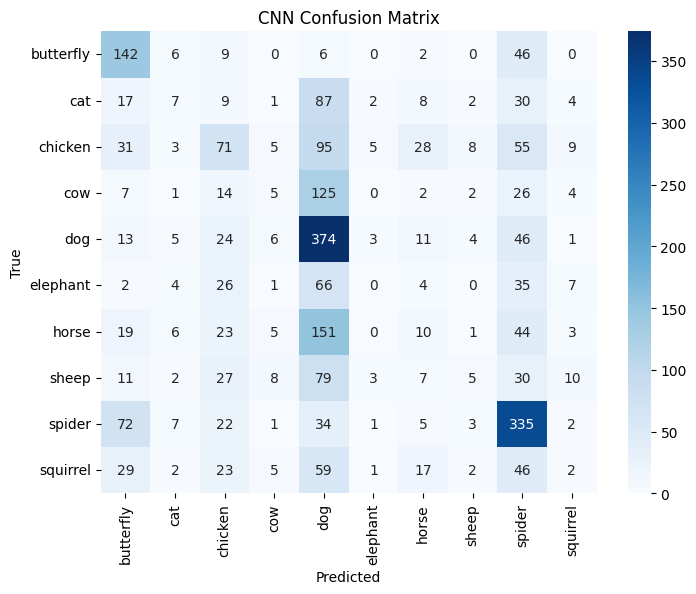

In [18]:
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### **Classification Report**
*   Displays precision, recall, F1-score, and support for each class.

*   Useful for understanding per-class performance.

In [19]:
print("CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

CNN Classification Report:
              precision    recall  f1-score   support

   butterfly       0.41      0.67      0.51       211
         cat       0.16      0.04      0.07       167
     chicken       0.29      0.23      0.25       310
         cow       0.14      0.03      0.04       186
         dog       0.35      0.77      0.48       487
    elephant       0.00      0.00      0.00       145
       horse       0.11      0.04      0.06       262
       sheep       0.19      0.03      0.05       182
      spider       0.48      0.70      0.57       482
    squirrel       0.05      0.01      0.02       186

    accuracy                           0.36      2618
   macro avg       0.22      0.25      0.20      2618
weighted avg       0.27      0.36      0.28      2618



# **ResNet50**

## **Building a Transfer Learning Model with ResNet50**

Define a function to build a CNN classifier using **ResNet50** as a base model for transfer learning.

In [34]:
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [35]:
train_ds_resnet, label_to_index_resnet = create_dataset(train_df, img_size=(224,224), model_preprocess=resnet_preprocess, training=True)
val_ds_resnet, _ = create_dataset(val_df, img_size=(224,224), model_preprocess=resnet_preprocess)
test_ds_resnet, _ = create_dataset(test_df, img_size=(224,224), model_preprocess=resnet_preprocess)

## **Training ResNet50**


In [36]:
resnet_model = build_resnet_model(input_shape=(224,224,3), num_classes=10)
callbacks_resnet = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_resnet_model.keras', monitor='val_accuracy', save_best_only=True)
]
resnet_model.fit(train_ds_resnet, validation_data=val_ds_resnet, epochs=10, callbacks=callbacks_resnet)


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 123s 167ms/step - accuracy: 0.7206 - loss: 0.9242 - val_accuracy: 0.9244 - val_loss: 0.2457 - learning_rate: 1.0000e-04
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 136ms/step - accuracy: 0.9189 - loss: 0.2646 - val_accuracy: 0.9354 - val_loss: 0.2113 - learning_rate: 1.0000e-04
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 92s 137ms/step - accuracy: 0.9341 - loss: 0.2199 - val_accuracy: 0.9427 - val_loss: 0.1990 - learning_rate: 1.0000e-04
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 88s 130ms/step - accuracy: 0.9403 - loss: 0.1962 - val_accuracy: 0.9423 - val_loss: 0.1970 - learning_rate: 1.0000e-04
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 143s 131ms/step - accuracy: 0.9461 - loss: 0.1763 - val_accuracy: 0.9419 - val_loss: 0.1899 - learning_rate: 1.0000e-04
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 147s 138ms/step - accuracy: 0.9515 - loss: 0.1572 - val_accuracy: 0.9454 - val_loss: 0.1821 - learning_rate: 1.0000e-04
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 94

## **Model Evaluation on Test Set**

Evaluate the performance of the ResNet50 model on the test dataset.

In [38]:
resnet_model = tf.keras.models.load_model('best_resnet_model.keras')
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_ds_resnet)
print(f'ResNet50 Test Accuracy: {test_acc_resnet:.2f}')

82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.9474 - loss: 0.1523
ResNet50 Test Accuracy: 0.95


###  **Predicting Labels**
We generate predictions for each batch in the test set:

In [39]:
y_true_resnet = []
y_pred_resnet = []
for images, labels in test_ds_resnet:
    preds = resnet_model.predict(images)
    y_true_resnet.extend(labels.numpy())
    y_pred_resnet.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

### **Confusion Matrix**


*   Visualizes how well the model distinguishes between classes.

*   Helps identify which classes are commonly confused.

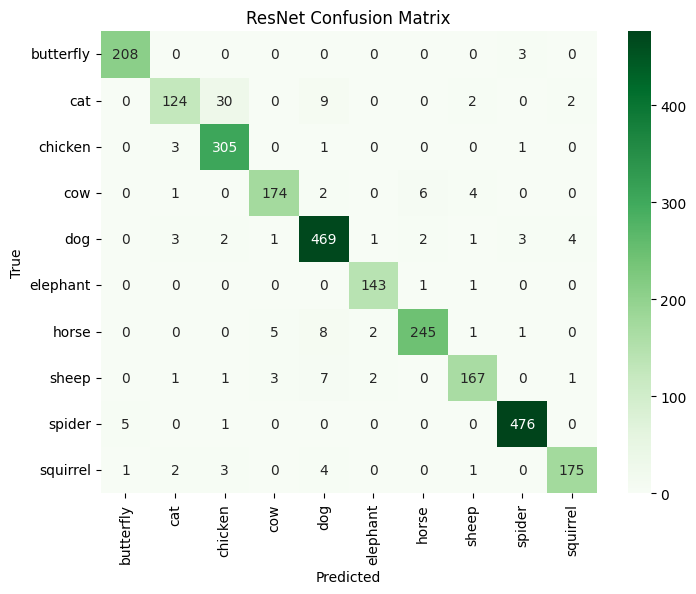

In [40]:
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(8,6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### **Classification Report**
*   Displays precision, recall, F1-score, and support for each class.

*   Useful for understanding per-class performance.

In [42]:
print("ResNet Classification Report:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))

ResNet Classification Report:
              precision    recall  f1-score   support

   butterfly       0.97      0.99      0.98       211
         cat       0.93      0.74      0.82       167
     chicken       0.89      0.98      0.94       310
         cow       0.95      0.93      0.94       187
         dog       0.94      0.97      0.95       486
    elephant       0.97      0.99      0.98       145
       horse       0.96      0.94      0.95       262
       sheep       0.94      0.92      0.93       182
      spider       0.98      0.99      0.99       482
    squirrel       0.96      0.94      0.95       186

    accuracy                           0.95      2618
   macro avg       0.95      0.94      0.94      2618
weighted avg       0.95      0.95      0.95      2618



# **Predicting and Displaying a Single Image**

In this section, we use our trained model to make a prediction on a new image.

- The image is loaded and prepared just like the training images.
- The model then predicts which class (animal) the image most likely belongs to.
- The result is shown visually with the image and the predicted label displayed on top.

This is a simple way to test the model on any image and see how well it performs!

In [30]:
def predict_and_show(img_path, model, label_to_index, model_preprocess=None):
    # Preprocess image using your existing pipeline
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    if model_preprocess:
        img = model_preprocess(img)
    else:
        img = img / 255.0
    img = tf.expand_dims(img, axis=0)

    # Predict
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    index_to_label = {v: k for k, v in label_to_index.items()}
    pred_label = index_to_label[pred_class]

    # Display
    plt.imshow(plt.imread(img_path))
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')
    plt.show()
    print("Predicted class:", pred_label)

Saving images.jpeg to images.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


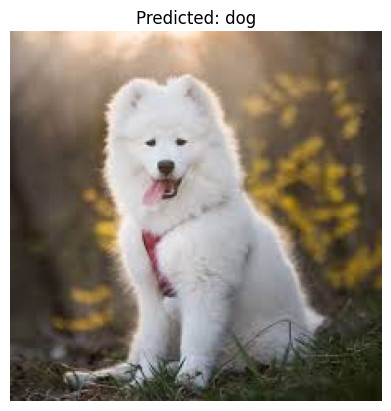

Predicted class: dog


In [49]:
from google.colab import files
uploaded = files.upload()

img_path = next(iter(uploaded))

predict_and_show(
    img_path,
    model=resnet_model,
    label_to_index=label_to_index_resnet,
    model_preprocess=resnet_preprocess
)